```{index} single: Pyomo; block 
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic programming; exponential cones
```
```{index} single: solver; mosek
```
```{index} single: application; portfolio
```
```{index} single: application; investment
```

# The Kelly Criterion

The Kelly Criterion determines the size of a bet in a repeated game with binary outcomes. The analysis was proposed in 1956 by John Kelly at Bell Laboratories. Kelly identified an analogy between gambling on binary outcomes and Claude Shannon's work on encoding information for transmission on noisy channels. Kelly used the analogy to show

> The maximum exponential rate of growth of the gambler's capital is equal to the rate of transmission of information over the channel.

This idea actually predates Kelly. In 1738, Daniel Bernoulli offered a resolution to the [St. Petersburg paradox](https://plato.stanford.edu/entries/paradox-stpetersburg/) proposed by his cousin, Nicholas Bernoulli. The resolution was to allocate bets among alternative outcomes to produce the highest geometric mean of returns. Kelly's analysis has been popularized by William Poundstone in his book "Fortune's Formula", and picked up by gamblers with colorful adventures in Las Vegas by early adopters though the result laid in obscurity among investors until much later.

This notebook presents solutions to Kelly's problem using exponential cones. A significant feature of this notebook is the inclusion of risk constraints recently proposed by Boyd and coworkers. These notes are based on recent papers by Busseti, Ryu, and Boyd (2016), Fu, Narasimhan, and Boyd (2017). Additional bibliographic notes are provided at the end of the notebook.

In [1]:
# install Pyomo and solvers
import sys

if "google.colab" in sys.modules:
    !pip install -q idaes-pse >/dev/null 2>/dev/null
    !idaes -q get-extensions
    import idaes
    conic_solver = "/root/.idaes/bin/ipopt"

else:
    conic_solver = "mosek_direct"

## Optimal Log Growth

The problem addressed by Kelly is to maximize the rate of growth of an investor's wealth. At every stage $n=1,\dots,N$, the gross return $R_n$ on the investor's wealth $W_n$ is given by

$$W_n = W_{n-1} R_n.$$

After $N$ stages, this gives

$$
W_N = W_0 R_1 R_2 \cdots R_{N-1} R_N = W_0 \prod_{n=1}^N R_n.
$$

Kelly's idea was to maximize the **mean log return**. Intuitively, this objective can be justified as we are simultaneously maximizing the geometric mean return

$$\left(\prod_{n=1}^N R_n\right)^{\frac{1}{N}} = \exp\left(\frac{1}{N}\sum_{n=1}^N \log R_n\right)$$

and the expected logarithmic utility of wealth

$$
\begin{align}
\log W_N & = \log W_0 \left(\sum_{n=1}^N \log R_n\right).
\end{align}
$$

The logarithmic utility provides an element of risk aversion. If the returns $R_i$'s are independent and identically distributed random variables, then in the long run, 

$$
\begin{align}
\mathbb{E}[\log W_N] & = \log W_0\ \mathbb{E}[\log R]
\end{align}
$$

such that the optimal log growth return will almost surely result in higher wealth than any other policy.

## Modeling a Game with Binary Outcomes

The classical presentation of the Kelly Criterion is to consider repeated wagers on a gambling game with binary outcomes. For each stage, a wager of one unit returns $1+b$ with probability $p$ if successful, otherwise the wager returns nothing. The number $b$ refers to the "odds" of game. The problem is to determine what fraction of the gambler's wealth should be wagered on each instance of the game.

![](kelly-criterion.png)

Let $w$ be the fraction of wealth that is wagered on each instance. Depend on the two possible outcome, the gross return at any stage is

$$
\begin{align}
R = \begin{cases}
1 + b w & \text{ with probability }p \\
1 - w & \text{ with probability }1-p.
\end{cases}
\end{align}
$$

The objective is to the maximize the expected log return

$$
\begin{align}
\max_{w\geq 0} \, p \log (1 + bw) + (1-p) \log (1 - w).\\
\end{align}
$$

The well-known analytical solution $w^*$ to this problem can be calculated to be

$$
w^* = 
\begin{cases} 
p - \frac{1-p}{b} & p(b+1) > 1, \\ 
0 & p(b+1)\leq 1.
\end{cases}
$$

We can use this analytical solution to validate the solution of this problem that we will now obtain using conic programming.

### Conic program 

Recall that an [exponential cone](https://docs.mosek.com/modeling-cookbook/expo.html) is a convex set $\mathbf{K}_{\mathrm{exp}} $ of $\mathbb{R}^3$ whose points $(r, x, y)$ satisfy the inequality 

$$r \geq x \exp{\frac{y}{x}} \quad \text{ if } \quad x \geq 0,$$ 

or the inequalities $r \geq 0$ and $y \leq 0$ if $x=0$. 

Introducing two auxiliary variables $q_1$ and $q_2$ and taking the exponential of the terms in the objective function, we obtain

$$q_1 \leq \log (1 + bw) \iff \exp{q_1} \leq 1 + b w \iff (1 + bw, 1, q_1) \in \mathbf{K}_{\mathrm{exp}},$$

and

$$q_2 \leq \log (1 - w) \iff \exp{q_2} \leq 1 - w \iff (1 - w, 1, q_2) \in \mathbf{K}_{\mathrm{exp}}.$$ 

With these constraints, Kelly's problem becomes

$$
\begin{align}
\max\quad & p q_1 + (1-p)q_2 \\
\text{s.t.}\quad & (1 + bw, 1, q_1) \in \mathbf{K}_{\mathrm{exp}} \\
& (1 - w, 1, q_2) \in \mathbf{K}_{\mathrm{exp}}\\
& w \geq 0 \\
& q_1, q_2 \in \mathbb{R}.
\end{align}
$$

The following code shows how to obtain the optimal solution using the conic programming functions of the Pyomo kernel library and the Mosek solver.

In [2]:
import pyomo.kernel as pmo

# parameter values
b = 1.25
p = 0.51

# conic programming solution to Kelly's problem 
def kelly(p, b):

    m = pmo.block()

    # decision variables
    m.q1 = pmo.variable()
    m.q2 = pmo.variable()
    m.w = pmo.variable(lb=0)

    # objective
    m.ElogR = pmo.objective(p*m.q1 + (1-p)*m.q2, sense=pmo.maximize)

    # conic constraints
    m.t1 = pmo.conic.primal_exponential.as_domain(1 + b*m.w, 1, m.q1)
    m.t2 = pmo.conic.primal_exponential.as_domain(1 - m.w, 1, m.q2)

    # solve
    pmo.SolverFactory(conic_solver).solve(m)

    return m.w()

w_conic = kelly(p, b)
print(f"Conic programming solution for w: {w_conic: 0.4f}")

# analytical solution to Kelly's problem
w_analytical = p - (1 - p)/b if p*(b + 1) > 1 else 0
print(f"Analytical solution for w: {w_analytical: 0.4f}")

Conic programming solution for w:  0.1180
Analytical solution for w:  0.1180


## Risk-constrainted version of the Kelly's problem

Following Busseti, Ryu, and Boyd (2016), we consider the risk-constrained version of the Kelly's problem, in which we add the constraint

$$\mathbb{E}[R^{-\lambda}] \leq 1,$$

where $\lambda \geq 0$ is a risk-aversion parameter. For the case with two outcomes $R_1$ and $R_2$ with known probabilities $p_1$ and $p_2$ considered here, this constraint rewrites as

$$p_1 R_1^{-\lambda} + p_2 R_2^{-\lambda} \leq 1.$$

When $\lambda=0$ the constraint is always satisfied and no risk-aversion is in effect. Choosing $\lambda > 0$ requires outcomes with low return to occur with low probability and this effect increases for larger values of $\lambda$. A feasible solution can always be found by setting the bet size $w=0$ to give $R_1 = 1$ and $R_2 = 0$.

This constraint can be reformulated using exponential cones. Rewriting each term as an exponential results gives

$$e^{\log(p_1) - \lambda\log(R_1)}  + e^{\log(p_2) - \lambda\log(R_2)} \leq 1.$$

We previously introduced two auxiliary real variables $q_1,q_2 \in \mathbb{R}$ such that $q_i \leq \log(R_i)$, using which we can reformulate the risk constraint as

$$e^{\log(p_1) - \lambda q_1}  + e^{\log(p_2) - \lambda q_2} \leq 1.$$

Introducing two more nonnegative auxiliary variables $u_1,u_2 \geq 0$ such that $u_i \geq e^{\log(p_i) - \lambda q_i}$, the risk constraint is given by

$$
\begin{align}
u_1 + u_2 & \leq 1 \\
(u_1, 1, \log(p_1) - \lambda q_1) & \in \mathbf{K}_{\mathrm{exp}} \\
(u_2, 1, \log(p_2) - \lambda q_2) & \in \mathbf{K}_{\mathrm{exp}}.
\end{align}
$$

For fixed probabilities $p_1=p$ and $p_2=1-p$, odds $b$, and risk-aversion parameter $\lambda \geq 0$, the risk-constrained Kelly bet is a solution to the conic program rewrites as

$$
\begin{align}
\max\quad & p q_1 + (1-p)q_2 \\
\text{s.t.}\quad 
& (1 + bw, 1, q_1) \in \mathbf{K}_{\mathrm{exp}} \\
& (1 - w, 1, q_2) \in \mathbf{K}_{\mathrm{exp}} \\
& u_1 + u_2 \leq 1 \\
& (u_1, 1, \log(p) - \lambda q_1) \in \mathbf{K}_{\mathrm{exp}} \\
& (u_2, 1, \log(1-p) - \lambda q_2) \in \mathbf{K}_{\mathrm{exp}}\\
& u_1, u_2, w \geq 0 \\
& q_1, q_2 \in \mathbb{R}.
\end{align}
$$

The following cell solves this problem with a Pyomo model using the Mosek solver.

In [3]:
import pyomo.kernel as pmo
import numpy as np

# parameter values
b = 1.25
p = 0.51
lambd = 3

# conic programming solution to Kelly's problem 
def kelly_rc(p, b, lambd):

    m = pmo.block()

    # decision variables
    m.q1 = pmo.variable()
    m.q2 = pmo.variable()
    m.w = pmo.variable(lb=0)

    # objective
    m.ElogR = pmo.objective(p*m.q1 + (1-p)*m.q2, sense=pmo.maximize)

    # conic constraints
    m.t1 = pmo.conic.primal_exponential.as_domain(1 + b*m.w, 1, m.q1)
    m.t2 = pmo.conic.primal_exponential.as_domain(1 - m.w, 1, m.q2)
    
    # risk constraints
    m.u1 = pmo.variable(lb=0)
    m.u2 = pmo.variable(lb=0)
    m.r0 = pmo.constraint(m.u1 + m.u2 <= 1)
    m.r1 = pmo.conic.primal_exponential.as_domain(m.u1, 1, np.log(p) - lambd*m.q1)
    m.r2 = pmo.conic.primal_exponential.as_domain(m.u2, 1, np.log(1 - p) - lambd*m.q2)

    # solve
    pmo.SolverFactory(conic_solver).solve(m)

    return m.w()

w_rc = kelly_rc(p, b, lambd)
print(f"Risk-constrainend solution for w: {w_rc: 0.4f}")

# solution to Kelly's problem
w_analytical = p - (1 - p)/b if p*(b+1) >= 1 else 0
print(f"Analytical solution for w: {w_analytical: 0.4f}")

Risk-constrainend solution for w:  0.0589
Analytical solution for w:  0.1180


## Simulation

The following cells simulate the performance of the Kelly Criterion both with and without risk constraints. Compare the cases by comparing the log mean growth, which is reduced by presence of risk constraints, and the portfolio draw down for the most pathological cases, which is improved by the presence of risk constraints.

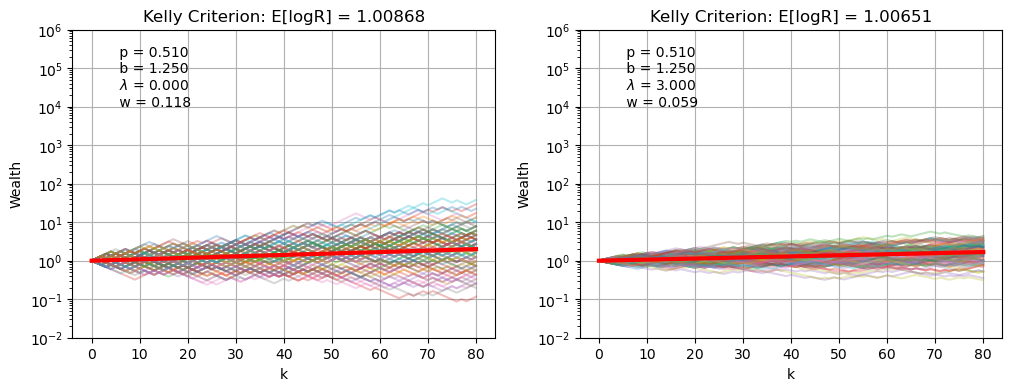

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def kelly_sim(p, b, lambd=0, K=None, ax=None):
    w = kelly_rc(p, b, lambd)
    m = p*np.log((1 + b*w)) + (1 - p)*np.log((1 - w))   
    
    if K is None:
        K = int(np.log(10)/m)
    if ax is None:
        _, ax = plt.subplots(1, 1)
        
    # monte carlo simulation and plotting
    for n in range(0, 100):
        W = [1]
        R = [[1 - w, 1 + w*b][z] for z in np.random.binomial(1, p, size=K)]
        R.insert(0, 1)
        ax.semilogy(np.cumprod(R), alpha=0.3)

    ax.semilogy(np.linspace(0,K), np.exp(m*np.linspace(0, K)), 'r', lw=3)  
    ax.set_title(f'Kelly Criterion: E[logR] = {np.exp(m):0.5f}')
    s = f" p = {p:0.3f} \n b = {b:0.3f} \n $\lambda$ = {lambd:0.3f} \n w = {w:0.3f}"
    ax.text(0.1, 0.95, s, transform=ax.transAxes, va="top")   
    ax.set_xlabel('k')
    ax.set_ylabel('Wealth')
    ax.grid(True)
    ax.set_ylim(0.01, 1e6)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

kelly_sim(p, b, lambd=0, K=80, ax=ax[0])
kelly_sim(p, b, lambd=3, K=80, ax=ax[1])

## Bibliographic Notes

The Kelly Criterion has been included in many tutorial introductions to finance and probability, and the subject of popular accounts.

> Poundstone, W. (2010). Fortune's formula: The untold story of the scientific betting system that beat the casinos and Wall Street. Hill and Wang. https://www.onlinecasinoground.nl/wp-content/uploads/2020/10/Fortunes-Formula-boek-van-William-Poundstone-oa-Kelly-Criterion.pdf

> Thorp, E. O. (2017). A man for all markets: From Las Vegas to wall street, how i beat the dealer and the market. Random House.

> Thorp, E. O. (2008). The Kelly criterion in blackjack sports betting, and the stock market. In Handbook of asset and liability management (pp. 385-428). North-Holland. https://www.palmislandtraders.com/econ136/thorpe_kelly_crit.pdf

>  https://en.wikipedia.org/wiki/Kelly_criterion

The utility of conic programming to solve problems involving log growth is more recent. Here are some representative papers.

> Busseti, E., Ryu, E. K., & Boyd, S. (2016). Risk-constrained Kelly gambling. The Journal of Investing, 25(3), 118-134. https://arxiv.org/pdf/1603.06183.pdf

> Fu, A., Narasimhan, B., & Boyd, S. (2017). CVXR: An R package for disciplined convex optimization. arXiv preprint arXiv:1711.07582. https://arxiv.org/abs/1711.07582
